In [2]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using MPSKit
using TensorKit
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using FileIO
using JLD2
Makie.inline!(true)
include("julia_functions.jl")



modify_approx_sizes_schimdt_compatible (generic function with 1 method)

Definition of the relevant transformation functions in the notebook below:

Transform the full tensornetwork to the tree structure by sequentially applying the transformation defined in taken path

But first - redefinition of all the relevant functions

In [20]:
TN = generate_random_quantum_circuit_2d_2xn(2,3, 5, 2)
graph, tv_map, ie_map, weighted_edge_list, ei_map = extract_graph_representation(TN)

(SimpleGraph{Int64}(45, [[6, 7, 28], [13, 15, 17], [4], [3, 24, 25], [26, 29, 36], [1, 30, 36], [1, 10, 23], [23, 31, 36], [10, 22, 30], [7, 9, 13]  …  [12], [1, 25, 29], [5, 19, 28], [6, 9, 14], [8, 13, 14], [23, 25, 26], [15], [14, 15, 16], [17], [5, 6, 8]]), Dict{Int64, Tenet.Tensor}(5 => [-0.5403023058681398 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 - 0.8414709848078965im;;; 0.0 + 0.0im 0.0 + 0.8414709848078965im; -0.5403023058681398 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.5403023058681398 + 0.0im; 0.0 - 0.8414709848078965im 0.0 + 0.0im;;; 0.0 + 0.8414709848078965im 0.0 + 0.0im; 0.0 + 0.0im 0.5403023058681398 + 0.0im], 16 => [-0.5403023058681398 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.8414709848078965im;;; 0.0 + 0.0im 0.0 + 0.8414709848078965im; -0.5403023058681398 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.5403023058681398 + 0.0im; 0.0 - 0.8414709848078965im 0.0 + 0.0im;;; 0.0 - 0.8414709848078965im 0.0 + 0.0im; 0.0 + 0.0im 0.5403023058681398 + 0.0im], 20 => [-1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.

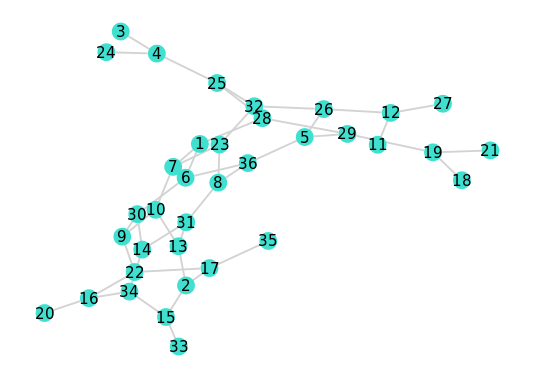

Amount of loops = 10


TN_tree_transform_approximate (generic function with 2 methods)

In [21]:

# plot the graph structure of the initial graph
display(gplot(graph, nodelabel=[i for i in 1:nv(graph)], layout=spring_layout))

println("Amount of loops = ", length(minimum_cycle_basis(graph)))

function extract_partial_tn_loop(TN, index_cycle, printing = false)

    """
    Based on the index in the index cycle crop out a part of the tensor network
    and return this local LOOP-TensorNetwork.
    """
    tensors_in_loop = collect(Set([tensor for id in index_cycle for tensor in Tenet.select(TN, [id])])) #correct orderding of variable definitions

    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end
        
    return current_tn
end

function collect_tensors_along_loop(loop_tn, index_cycle, index_to_cut)

    """
    Funtion whcih sequentially walks along the index cycle in the correct order
    loop and selects the relevant tensors.
    Return a list of tensors which is correctly ordered along the loop.
    """
    
    global start_tensor
    global end_tensor

    connectedtensors = Tenet.select(loop_tn, index_to_cut)
    firstsymbol = index_cycle[1]
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end

    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != connecting_id[1], index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end
    
    return tensors_ordered_loop
end


function new_node_cycle(node_cycle::Vector{Int}, edge_to_cut::Tuple{Int, Int})

    """
    Put the node cycle in the correct ordering which places the node cycle
    in the correct form the extract the MPS.
    """
    
    for i in 1:length(node_cycle)
        node_perm = circshift( node_cycle, i-1)
        first_index = findfirst(x -> x == edge_to_cut[1], node_perm)
        second_index = findfirst(x -> x == edge_to_cut[2], node_perm)
        if sort([first_index, second_index]) == [1, length(node_cycle)]
            node_cycle = node_perm
            break
        end
    end
    return node_cycle
end


function compress_Tenet_MPS(TenetMPS, physical_order, inds_connecting, chi_max, printing = false, exact = false)

    println("___________Starting MPSKit conversion and compression___________")

    """
    Function which takes in a TenetMPS, a order of the physical indices,
    and a max allowed bond dimension chi_max. Compresses the TenetMPS using a conversion to MPSKit
    and DMRG variational compression. After compression reconverts to TenetMPS and returns
    the compressed TenetMPS.
    """
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    physical_order = [id for id in physical_order]
    
    """
    Contract these the edge nodes to form a MPSKit compatible MPS.
    """

    tv1 = Tenet.select(TenetMPS, [physical_order[1]])[1]
    tv2 = Tenet.select(TenetMPS, [physical_order[end]])[1]

    v1 = setdiff(inds(tv1), [physical_order[1]])[1]
    v2 = setdiff(inds(tv2), [physical_order[end]])[1]
    contraction_step(TenetMPS, v1)
    contraction_step(TenetMPS, v2)

    if length(Tenet.tensors(TenetMPS)) == 1
        println("smallest loop detected => reduced to one tensor")
        return TenetMPS
    end
   
    global ids 

    T_ordered = []
    inds_connection = []
    left_index = physical_order[1]

    for i in 1:length(Tenet.tensors(TenetMPS))
        if i == 1
            for t in Tenet.tensors(TenetMPS)
                ids = inds(t)
                if !isempty(intersect(inds(t), [left_index]))
                    push!(T_ordered, t)
                    break
                end
            end
        end
        for t in Tenet.tensors(TenetMPS)
            if t ∉ T_ordered
                if !isempty(intersect(inds(t), ids))
                    push!(inds_connection, intersect(inds(t), ids)[1])
                    push!(T_ordered, t)
                    ids = inds(t)
                end
            end
        end
    end
    
    inds_connection = [id for id in inds_connection]
    pushfirst!(inds_connection, v1)
    push!(inds_connection, v2)


    first = [physical_order[1], physical_order[2], inds_connection[2]]
    last = [inds_connection[end-1], physical_order[end-1], physical_order[end]]
   
    permutation_list = []
    for i in 3:length(physical_order)-2
        push!(permutation_list, [inds_connection[i-1], physical_order[i], inds_connection[i]])
    end

    pushfirst!(permutation_list, first)
    push!(permutation_list, last)

    extracted_maps = []
    approximate_extracted_maps = []
    approximate_sizes_list = []
    real_sizes_list = []
    println("___________Extracting the TensorMaps___________")

    """
    Extract the TensorKit Maps
    """
    #TODO: Does something go wrong in the edge cases?
    for (i, t) in enumerate(T_ordered)
        t = permutedims(t, permutation_list[i])
        push!(extracted_maps, TensorMap(t.data, ℂ^(size(t, inds(t)[1])) ⊗ ℂ^(size(t, inds(t)[2])), ℂ^(size(t, inds(t)[3]))))
        push!(real_sizes_list, (size(t, inds(t)[1]), size(t, inds(t)[2]), (size(t, inds(t)[3]))))
        # Always keep the correct physical size
        # Keep the bond dimension to the chi_max value or smaller
        # take min(chi_max, needed dim) in the virtual connecting spaces
        
        
        push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, minimum([chi_max, size(t, inds(t)[1])]), 
                                                                    (size(t, inds(t)[2])), 
                                                                    minimum([chi_max, size(t, inds(t)[3])])),
                                                                    ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
                                                                     ℂ^minimum([chi_max, size(t, inds(t)[3])])))
        push!(approximate_sizes_list, (minimum([chi_max, size(t, inds(t)[1])]), (size(t, inds(t)[2])), minimum([chi_max, size(t, inds(t)[3])])))
    end

    extracted_maps = [map for map in extracted_maps]
    approximate_extracted_maps = [map for map in approximate_extracted_maps]

    println("___________Creating the MPSKit MPSs___________")

    mps_exact = FiniteMPS(extracted_maps)
    mps_approximate = FiniteMPS(approximate_extracted_maps)
  

    """
    Run the compression algorithm 
    """

    # Create a DMRG algorithm instance
    alg = DMRG(;  # Choose DMRG (1-site) for this example
            maxiter = 20,  # Maximum number of iterations
            verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
            tol = 1e-16
            )
    
    println("___________Performing the compression___________")
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(mps_exact)), physicalspace(mps_exact, i))) for i in 1:length(mps_exact)]) # corresponding identity operator as an MPO
    mps_new, = approximate(mps_approximate, (I_MPO, mps_exact), alg)
       
    local_fidelity_mpskit = abs(dot(mps_new, mps_exact))^2/(abs(dot(mps_new, mps_new))*abs(dot(mps_exact, mps_exact)))
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    println("_____________Local fidelity analysis MPSKit.jl_____________")
    println("|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = ", 1-local_fidelity_mpskit)
    push!(local_error_list, 1-local_fidelity_mpskit)
    """
    Reconvert to Tenet.TensorNetwork compatible format
    """
    #because not QR sizes anymore we must modify
    approximate_sizes_list = modify_approx_sizes_schimdt_compatible(approximate_sizes_list)
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    new_tenet_tensors = []
    for i in 1:length(mps_new)
        if i == length(mps_new)
            shaped_data = reshape(mps_new.AC[i].data, (approximate_sizes_list[i]))
            new_t = Tenet.Tensor(shaped_data, permutation_list[i])
            push!(new_tenet_tensors, new_t)
            break
        end
        

        shaped_data = reshape(mps_new.AL[i].data, (approximate_sizes_list[i]))
        new_t = Tenet.Tensor(shaped_data, permutation_list[i])
        push!(new_tenet_tensors, new_t)
    end

    TenetMPS = Tenet.TensorNetwork(new_tenet_tensors)
    return TenetMPS

end

global local_error_list = []

function LOOP_TO_APPROXIMATE_MPS(loop_tn, index_cycle, index_to_cut, chi_max, plotting = false, printing = false)

    """ 
    Function takes in the original loop tensor network and transform this to
    a partly contracted MPS tensor, which is approximated to chi_max.
    """
    
    # STEP 1: FORM LOOP TN => TRANSFORMABLE TO MPS

    """
    Take care of the case where no dangling edges are found: 
    => prematurely contract these tensors onto each other
    Create a MPS compatible loop TN 
    """

    fullcycle = deepcopy(index_cycle)


    # STEP 1.1 -- EXTRACT RELEVANT DATA BEFORE TRANSFORMING 

    """
    collect tensors along the loop from start_tensor to end_tensor
    and reorganize_cycle for correct ordering along the loop
    """
        
    for (idx, index) in enumerate(index_cycle)
        if index == index_to_cut[1]
            index_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
            break
        end
    end

    ordered_along_loop = collect_tensors_along_loop(loop_tn, deepcopy(index_cycle), index_to_cut)
    inds_connection = index_cycle

    physical_index_ordering = []
    for t in ordered_along_loop
        push!(physical_index_ordering, setdiff(inds(t), fullcycle)[1])
    end
    physical_index_ordering = [id for id in physical_index_ordering]

    """
    Extract the physical_index_ordering from the loop which allow the to create
    the correct MPS-structure based on the local LOOP-TensorNetwork.
    """

    # STEP 2: FORM EXACT MPS

    """ 
    define original loop and transform it into a MPS
    => return the mps tensor network and provide a local fidelity analysis
    """ 

    loop_net = deepcopy(loop_tn)
    if plotting == true
        drawing1 = Makie.plot(loop_net, node_color=[:darkred for i in 1:length(tensors(loop_net))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    virtual = [Symbol("v$i") for i in 1:1000] 
   

    """
    Transform the loop TensorNetwork into an exact MPS tensor
    """

    println("____________Creating MPS___________")

    mps_net, connection_indices = Tenet_loop_2_Tenet_MPS(loop_net, fullcycle, index_to_cut[1])

    println("sizes in the folded loop mps = ", [size(mps_net, id) for id in inds(mps_net, :inner)])


    """
    Convert TenetMPS to MPSKit MPS --> Apply compression function
    """

    mps_net = compress_Tenet_MPS(mps_net, physical_index_ordering, inds_connection, chi_max, false)


    """
    replace the virtual indices in the MPS with the correct cycle indices
    old => new
    """

    connection_indices = connection_indices[2:end-1]
    for i in 1:length(connection_indices)
        c1 = connection_indices[i]
        i1 = index_cycle[i]
        replace!(mps_net, connection_indices[i] => index_cycle[i])
    end
    
    return mps_net
end

function transform_to_MPS_QR_approximate(TN, edge_to_cut, node_cycle, chi_max, printing = false)

    """
    Function which takes in full tensor network, a cycle of tensor nodes
    and an edge to cut (tuple of two nodes).
    Returns the transformed TensorNetwork, were the loop defined by the cycle
    of nodes is replaced by the contracted MPS like structure.
    """

    # 1. TRANSFORM NODE CYCLE TO EDGE CYCLE

    cycle = new_node_cycle(node_cycle, edge_to_cut)
    edge_cycle = []
    # extract the edges from the current node cycle to check dictionary availability
    c_edges = [[cycle[i], cycle[i+1]] for i in 1:length(cycle)-1]
    push!(c_edges, [cycle[end], cycle[1]])
    for edge in c_edges
        push!(edge_cycle, Tuple(sort(edge)))
    end

    # 2. TRANSFORM EDGE CYCLE TO INDEX CYCLE
    indices = [ei_map[edge] for edge in edge_cycle]
    index_cycle = [index[1] for index in indices]
    fullcycle = deepcopy(index_cycle)
    index_to_cut = ei_map[edge_to_cut]
    # 3. EXTRACT THE LOOP NETWORK BASED ON THE INDEX CYCLE 

    loop_tn = extract_partial_tn_loop(TN, index_cycle, false)
    loop_indices = inds(loop_tn)
    old_loop = deepcopy(loop_tn)

    mps_network = LOOP_TO_APPROXIMATE_MPS(loop_tn, index_cycle, index_to_cut, chi_max, false, printing)
    
    # 4. MODIFY THE TN: pop! the LOOP and push! the MPS
    for id in fullcycle[1:end-1]
        # last one is already removed
        tens = Tenet.select(TN, id)
        for t in tens
            pop!(TN, t)
        end
    end

    for tensor in Tenet.tensors(mps_network)
        push!(TN, tensor)
    end

    return TN
end

function TN_tree_transform_approximate(TN, chi_max, plotting_final = false)

    """
    Function which takes in the TensorNetwork which contains_loops and a
    taken_path from the AlphaZero agent.
    Performs the deloopification by inserting exact MPS tree representations.

    Schematic of function calls:

    1. TN_tree_transform_approximate -> specify a chi max
    -> Select the smallest loop and pass this loop to LOOP_TO_APPROXIMATE_MPS

    2. LOOP_TO_APPROXIMATE_MPS
    -> Transforms a Tenet LOOP to a TenetMPS
    -> Compresses TenetMPS using MPSKit with 3

    3. compress_Tenet_MPS
    -> Transforms a TenetMPS to a MPSKit MPS
    -> Applies a compression algorithm based on truncating the  chi_max
    -> Transform the result back to a TenetMPS
    """

    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end


    with_loops = deepcopy(TN)
    println("Contracting initial network..... => amount of tensors = ", length(Tenet.tensors(with_loops)))
    path_loops = einexpr(with_loops, optimizer = Greedy())
    path = Makie.plot(path_loops)
    
    display(path)

    time_loop = @elapsed begin   
        T_loop = Tenet.contract(with_loops)
    end

    """
    Walk the action path and apply each action sequentially on the 
    LOOP-TensorNetwork. Replace the loop with the tree.
    """

    global g
    global tv_map
    global ie_map
    global ei_map

    g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)

    while length(minimum_cycle_basis(g)) > 0
        GC.gc()
        cycle_basis = minimum_cycle_basis(g)
        println("Current amount of loops in the network = ", length(cycle_basis))
        node_cycle = cycle_basis[1]   
        println("length node cycle = ", length(node_cycle))                     # choose smallest loop
        edge_to_cut = Tuple(sort([node_cycle[1], node_cycle[2]]))
        TN = transform_to_MPS_QR_approximate(TN, edge_to_cut, node_cycle, chi_max, true)
        current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
        println("current_mem_usage = ", current_mem_usage)
        g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)
    end

    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    """
    Calculating the overlaps and fidelities.
    """

    tree = deepcopy(TN)
    println("Contracting transformed tree network.... => Amount of tensors in the tree network = ", length(Tenet.tensors(tree)))
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    time_tree = @elapsed begin
        T_tree = Tenet.contract(TN)
    end
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    path_tree = einexpr(tree, optimizer=Greedy())
    println("cost of loopy contraction = ", mapreduce(flops, +, Branches(path_loops)))
    println("cost of treecontraction = ", mapreduce(flops, +, Branches(path_tree)))
    path = Makie.plot(path_tree)
    display(path)
   
    println("contraction_time with loops = ", time_loop, "[s]")
    println("contraction_time tree = ", time_tree, "[s]")


    overlap_looploop = abs((Tenet.contract(adjoint(T_loop), T_loop))[1])
    overlap_treetree = abs((Tenet.contract(adjoint(T_tree), T_tree))[1])
    overlap_full = abs((Tenet.contract(adjoint(T_tree), T_loop))[1])
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    println(" ---------------- GLOBAL FIDELITY ANALYSIS ------------ ")
    println("|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = ", abs(1-overlap_full^2/(overlap_looploop*overlap_treetree)))
    F = abs(1-overlap_full^2/(overlap_looploop*overlap_treetree))
    cost_loop = mapreduce(flops, +, Branches(path_loops))
    cost_tree = mapreduce(flops, +, Branches(path_tree))
    return TN, F, cost_tree, cost_loop, local_error_list
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
end





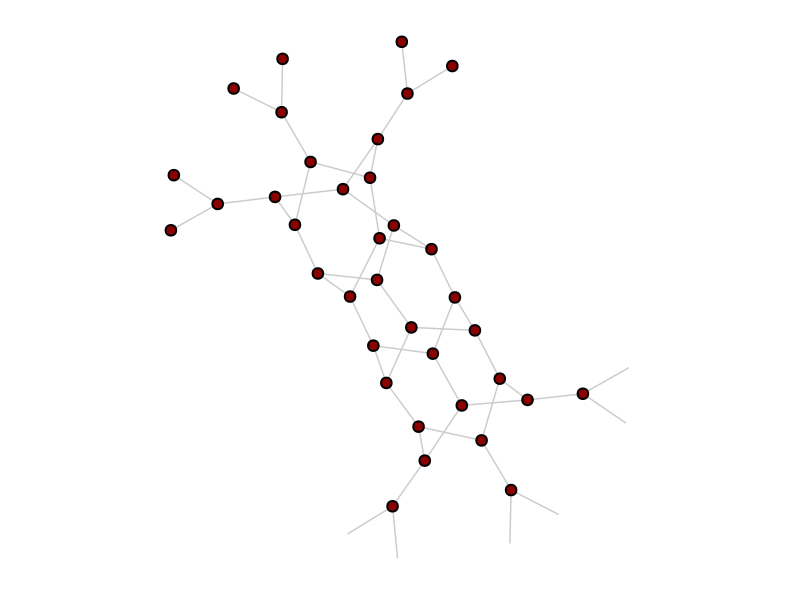

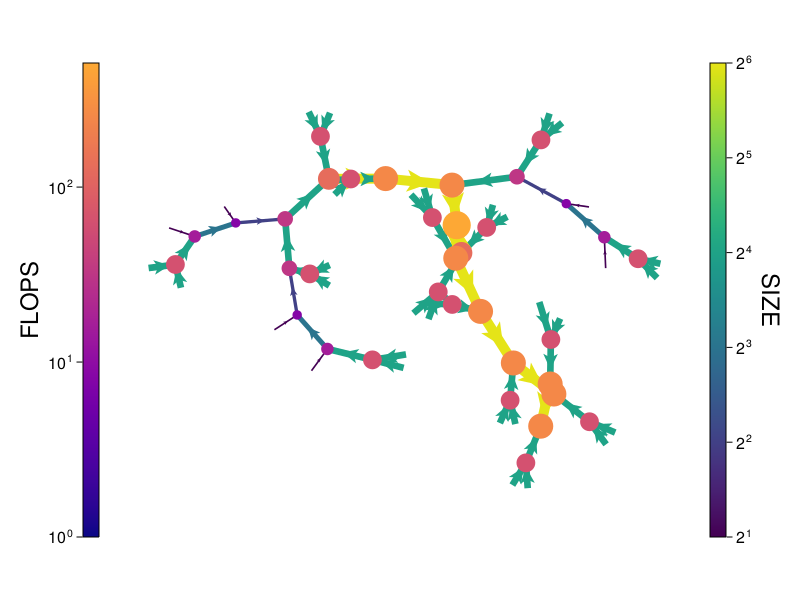

Contracting initial network..... => amount of tensors = 36
Current amount of loops in the network = 10
length node cycle = 6
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 2.220446049250313e-16
sizes in the folded loop mps = [4, 4, 8, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4088.55859375
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4088.55859375
current_mem_usage = 4087.01953125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
current_mem_usage = 4087.01953125
current_mem_usage = 4087.01953125


┌ Warning: dmrg failed to converge 7.001830009876161e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 9
length node cycle = 5
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 0.0
sizes in the folded loop mps = [8, 4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4087.64453125
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4087.64453125
current_mem_usage = 4087.64453125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
current_mem_usage = 4087.64453125
current_mem_usage = 4087.64453125


┌ Warning: dmrg failed to converge 9.167307853542288e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 8
length node cycle = 5
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 0.0
sizes in the folded loop mps = [16, 8, 8, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4089.56640625
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4089.56640625
current_mem_usage = 4089.56640625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
current_mem_usage = 4089.56640625
current_mem_usage = 4089.56640625


┌ Warning: dmrg failed to converge 1.1148032113513163e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 7
length node cycle = 5
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 0.0
sizes in the folded loop mps = [4, 4, 8, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4073.05078125
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4073.05078125
current_mem_usage = 4073.05078125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
current_mem_usage = 4073.05078125
current_mem_usage = 4073.05078125


┌ Warning: dmrg failed to converge 5.086858569714799e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 6
length node cycle = 5
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 4.440892098500626e-16
sizes in the folded loop mps = [64, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4069.4453125
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4069.8828125
current_mem_usage = 4079.46484375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.625
current_mem_usage = 4079.46484375
current_mem_usage = 4079.46484375


┌ Warning: dmrg failed to converge 1.8222264778075992e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 5
length node cycle = 5
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 5.551115123125783e-16
sizes in the folded loop mps = [96, 96, 96, 384]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4131.9375
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4060.75390625
current_mem_usage = 4062.32421875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.12518700092602797
current_mem_usage = 4062.32421875
current_mem_usage = 4062.32421875


┌ Warning: dmrg failed to converge 0.002949523456781166>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 4
length node cycle = 4
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 2.220446049250313e-16
sizes in the folded loop mps = [8, 32, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4060.0
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4060.0
current_mem_usage = 4052.11328125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
current_mem_usage = 4052.11328125
current_mem_usage = 4052.11328125


┌ Warning: dmrg failed to converge 7.522731774039244e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 3
length node cycle = 4
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 2.220446049250313e-16
sizes in the folded loop mps = [8, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4053.91796875
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4053.91796875
current_mem_usage = 4053.91796875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
current_mem_usage = 4053.91796875
current_mem_usage = 4053.91796875


┌ Warning: dmrg failed to converge 9.542008315197136e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Current amount of loops in the network = 2
length node cycle = 4
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 2.220446049250313e-16
sizes in the folded loop mps = [32, 32, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4069.0703125
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4069.5078125
current_mem_usage = 4070.0
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
current_mem_usage = 4070.0
current_mem_usage = 4070.0


┌ Warning: dmrg failed to converge 9.231516085401168e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


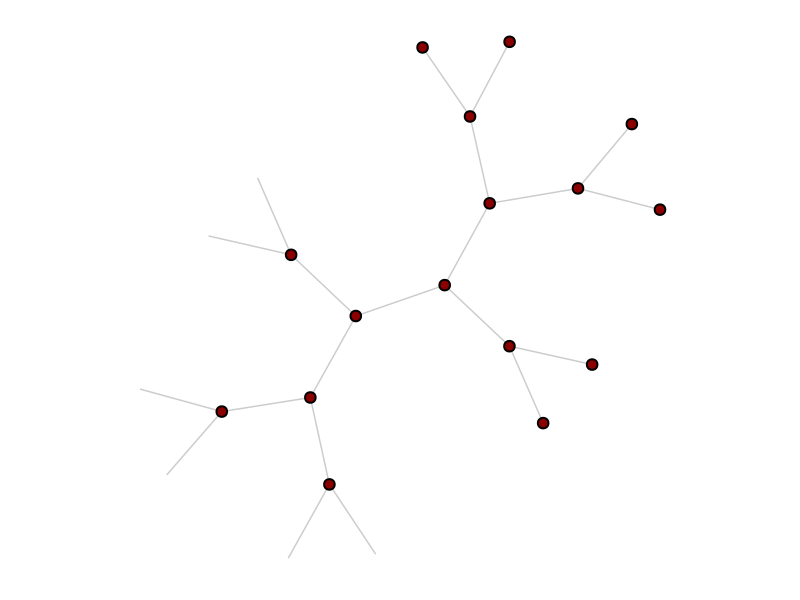

Current amount of loops in the network = 1
length node cycle = 4
____________Creating MPS___________
 ---------------- FIDELITY ANALYSIS MPS RESHAPE------------ 
|1- |< Loop- state | MPS - state >|^2 /(|< Loop - state | Loop - state >||< MPS - state | MPS - state >|)|  = 0.0
sizes in the folded loop mps = [16, 16, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 4061.6953125
___________Extracting the TensorMaps___________
___________Creating the MPSKit MPSs___________
___________Performing the compression___________
current_mem_usage = 4061.6953125
current_mem_usage = 4061.6953125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
current_mem_usage = 4061.6953125
current_mem_usage = 4063.171875


┌ Warning: dmrg failed to converge 1.0678791172633315e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


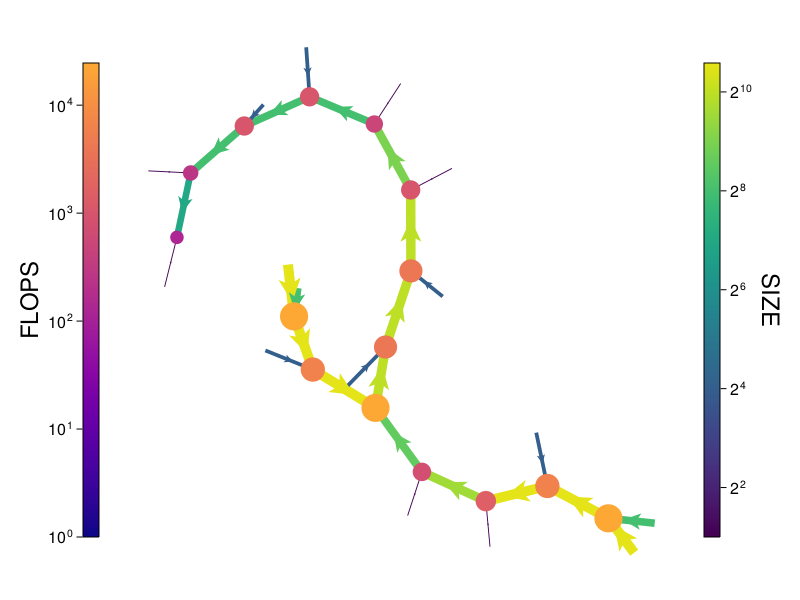

Contracting transformed tree network.... => Amount of tensors in the tree network = 16
current_mem_usage = 4055.58984375
current_mem_usage = 4055.58984375
cost of loopy contraction = 3944
cost of treecontraction = 100480
contraction_time with loops = 0.006376726[s]
contraction_time tree = 0.002077849[s]
current_mem_usage = 4060.50390625
 ---------------- GLOBAL FIDELITY ANALYSIS ------------ 
|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = 0.7229009606891477
Approximate transformation finished:
global error = 0.7229009606891477
local_error_list = Any[-4.440892098500626e-16, -2.220446049250313e-16, 2.220446049250313e-16, 0.0, 0.625, 0.12518700092602797, 0.0, -2.220446049250313e-16, -2.220446049250313e-16, -2.220446049250313e-16]
#tenosrs loop network = 36
#tenosrs tree network = 16
loop cost = 3944
tree cost = 100480


In [22]:
# Run this to approximately contract a LOOP_TN using small MPS based on smallest loops
tn1 = deepcopy(TN)
chi_max_list = [32,28,24,20,18,16,14,12,10,9,8,7,6,5,4]
chi_max_list = [24]
local_error_list = []
global_fidelity_list = []
tree_cost_list = []


for chi_max in chi_max_list
    tn1 = deepcopy(TN)
    global local_error_list = []
    tn1, globalF, tree_cost, loop_cost, local_error_list = TN_tree_transform_approximate(tn1, chi_max, true)
    println("Approximate transformation finished:")
    println("global error = ", globalF)
    println("local_error_list = ", local_error_list)
    println("#tenosrs loop network = ", length(Tenet.tensors(TN)))
    println("#tenosrs tree network = ", length(Tenet.tensors(tn1)))
    println("loop cost = ", loop_cost)
    println("tree cost = ", tree_cost)
end




In [ ]:
display(Makie.scatter!(collect(1:length(memory_usage_in))))

In [ ]:
global_fidelity_list = [x == 0 ? 1e-16 : x for x in global_fidelity_list]
local_error_list = [x == 0 ? 1e-16 : x for x in local_error_list]


p = Plots.scatter(chi_max_list, local_error_list, label="Local Error", xlabel="chi_max", ylabel="sum of local errors")
display(p)

p = Plots.scatter(chi_max_list, global_fidelity_list, label="Global error", xlabel="chi_max", ylabel="Global error")
display(p)

p = Plots.scatter(chi_max_list, tree_cost_list./tree, label="Greedy tree/loop cost", xlabel="chi_max", ylabel="Relative cost")
display(p)